# Gravity Field Calculation

This is about the implementation of a simple FEM solver in Python. First we look at the calculation of the 
gravity potential $u$ for a given density $\rho$. As introduced in class the PDE to be solved is given as
$$
     -\nabla^T \nabla u = - 4\pi G \rho \; .
$$
with the universal gravitational constant $G = 6.67430 \cdot 10^{−11}\frac{Nm^2}{kg^2}$. The gravity field $\mathbf{g}$ is given as the negative gradient of the gravity potential
$$
      \mathbf{g} = - \nabla u
$$


## Set up Grid and Domain

First step is to define the grid: 

- `N0` - number of element in the horizontal direction
- `N1` - number of element in the vertical direction

Initially we start with small grid:

In [22]:
N0, N1 = 5, 10

Total number of element `NE`?

In [23]:
NE=N0*N1
NE

50

Number of nodes:

- `NN0` - in horizontal direction
- `NN1` - in vertical direction

In [24]:
NN0, NN1 = N0+1, N1+1

Total number of nodes `N`

In [25]:
N=NN0 * NN1
N

66

We need a grid spacing `H` assuming the same spacing vertical and horizontal direction.

In [26]:
H=1000

What is the extend of the domain?

- `L0` - horizontal direction
- `L1` - vertical direction

In [27]:
L0, L1 = H*NE0, H*NE1

What exactly is the set up of domain and grid now?

In [21]:
print(f"Extend of domain : {L0} x {L1}")
print(f"total number of elements: {NE}")
print(f"total number of unknown: {N}")


Extend of domain : 5000 x 10000
total number of elements: 50
total number of unknown: 66


## Stiffness matrix

Next step is to assemble the stiffness matrix `Sh`. Recall that the stiffness matrix is sparse. To make use of this we use this we use the sparse matrix based on **Dictionary Of Keys** (DOK) where the key is a tuple that defines the row and column of a non-zero entry and the value the corresponding matrix entry.
This is an efficient structure for constructing sparse matrices incrementally which is what we are going to do while we running through all elements. 

We are going to use `dok_matrix` from `scipy.sparse` which provides an implementation of a DOK based sparse matrix. The full documentation for `dok_matrix` is available at [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html) 

To set-up the `dok_matrix` matrix we need to know its dimension.

In [30]:
from scipy.sparse import dok_matrix
Sh=dok_matrix((N,N))
Sh

<66x66 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Dictionary Of Keys format>

To fill the stiffness matrix we need to run over all elements $(i_0, i_1)$, calculate the local element matrix $\mathbf{S}^E$ and add the element matrix to the appropriate rows and columns. 

Recall that for the gravity case the local element matrix is given as
$$
\mathbf{S}^E = \hat{\mathbf{S}} 
$$
where
$$
    \hat{\mathbf{S}} = 
    \left[
    \begin{array}{rrrr}
    \frac{2}{3} & -\frac{1}{6} & -\frac{1}{6} & -\frac{1}{3}  \\
     -\frac{1}{6} & \frac{2}{3} & -\frac{1}{3}  &  -\frac{1}{6}  \\
     -\frac{1}{6} & -\frac{1}{3}  & \frac{2}{3} &  -\frac{1}{6}  \\
     -\frac{1}{3}  &  -\frac{1}{6} &  -\frac{1}{6}  & \frac{2}{3}
    \end{array}
    \right]
$$

Let's look at element $(i_0, i_1)=(1,0)$ first. This element is in the first row and second column.

In [43]:
i0, i1= 1,0

The element size independent element matrix $\hat{\mathbf{S}}$ is stored as `numpy` array:

In [44]:
import numpy as np
hatS=np.array([[2./3, -1./6, -1./6, -1./3], [-1./6, 2./3, -1./3, -1./6], [-1./6, -1./3, 2./3, -1./6], [-1./3, -1./6, -1./6, 2./3]])

In [45]:
hatS

array([[ 0.66666667, -0.16666667, -0.16666667, -0.33333333],
       [-0.16666667,  0.66666667, -0.33333333, -0.16666667],
       [-0.16666667, -0.33333333,  0.66666667, -0.16666667],
       [-0.33333333, -0.16666667, -0.16666667,  0.66666667]])

In [46]:
SE=hatS

In [47]:
SE.shape

(4, 4)

The rows and columns of `Sh` into which the element matrix is added are defined by the FEM node identification numbers of the vertices `Vids` that form the element. We copy this from the lecture:
$$
\mathtt{Vids}=[i_1 \cdot (N_0+1)+i_0, i_1  \cdot (N_0+1)+i_0+1, (i_1+1)  \cdot (N_0+1)+i_0, (i_1+1)  \cdot  (N_0+1)+i_0+1]
$$

In [48]:
Vids=[i1*NN0+i0, i1*NN0+i0+1, (i1+1)*NN0+i0, (i1+1)*NN0+i0+1]

Let see what this is for element $E=(i_0, i_1)=1,0$:

In [53]:
Vids

[1, 2, 7, 8]

iterative over the rows and columns of the element matrix and add to corresponding rows and columns in the stiffness matrix via the `Vids` list:

In [57]:
Sh.clear()
for ir in range(4):
    for ic in range(4): 
        Sh[Vids[ir], Vids[ic]]+=SE[ir, ic]

There should be at least $4 \times 4 =16$ entries in the stiffness matrix `Sh`:

In [55]:
Sh

<66x66 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Dictionary Of Keys format>

Where are the non-zero entries in the matrix? check the `keys`:

In [70]:
Sh.keys()

dict_keys([(1, 1), (1, 2), (1, 7), (1, 8), (2, 1), (2, 2), (2, 7), (2, 8), (7, 1), (7, 2), (7, 7), (7, 8), (8, 1), (8, 2), (8, 7), (8, 8)])

Now we are ready to assamble the entire stiffness matrix by iterating over all columns of elements `i0` and all rows of elements `i1` (note: `Sh` is cleared to remove the entries from the initial test): 

In [71]:
Sh.clear()
for i1 in range(NE1):
    for i0 in range(NE0):
        Vids=[i1*NN0+i0, i1*NN0+i0+1, (i1+1)*NN0+i0, (i1+1)*NN0+i0+1]
        for ir in range(4):
            for ic in range(4): 
                Sh[Vids[ir], Vids[ic]]+=SE[ir, ic]

Check the stiffness matrix:

In [74]:
Sh

<66x66 sparse matrix of type '<class 'numpy.float64'>'
	with 496 stored elements in Dictionary Of Keys format>

What are the maximum and minimum values in the matrix?

In [91]:
max(Sh.values()), min(Sh.values())

(2.6666666666666665, -0.3333333333333333)

The `matplotlib` provides a function `matshow` of a dense matrix so we need to convert the sparse matrix `Sh` into a dense matrix which can easily   

<IPython.core.display.Javascript object>


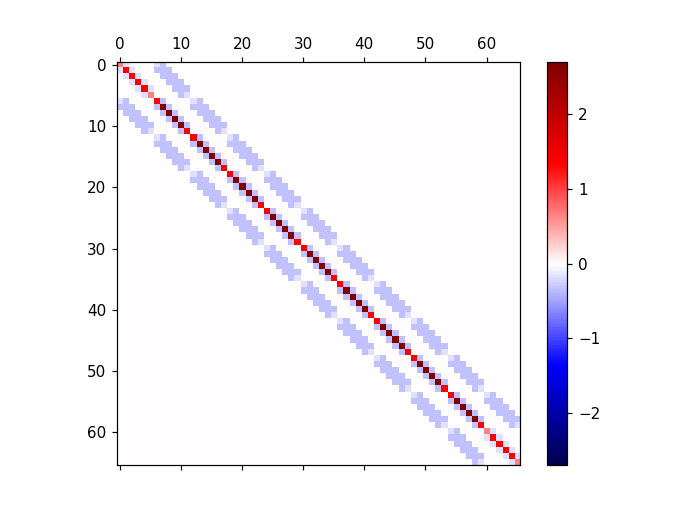

In [85]:
 %matplotlib notebook
import matplotlib.pyplot as plt
plt.clf()
plt.matshow(Sh.todense(), fignum=0, vmin=-2.7, vmax=2.7, cmap='seismic')
plt.colorbar()
plt.show()
